## Problem Set #5

MACS 30100, Dr. Evans 

Shuting Chen 

### 1. Multinomial logistic regression and cross validation

#### Part (a). 

In [177]:
import numpy as np 
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
%matplotlib inline
import matplotlib.pyplot as plt

In [178]:
# Import Data
drink = pd.read_csv('strongdrink.txt')
drink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [179]:
drink.cultivar.value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

In [180]:
X = drink[['alco', 'malic', 'tot_phen', 'color_int']]
y = drink.cultivar
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.25,
       random_state=20)
MultLogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
MultLogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

#### Estimated coefficients for j = 1

In [181]:
MultLogReg.coef_[0]

array([ 1.70043264, -0.26560971,  1.22389447,  0.02274778])

#### Estimated intercept for j = 1

In [182]:
MultLogReg.intercept_[0]

-24.011331526271427

#### Estimated coefficients for j = 2

In [183]:
MultLogReg.coef_[1]

array([-1.46798523, -0.33305092,  0.66400603, -0.92270882])

#### Estimated intercept for j = 2

In [184]:
MultLogReg.intercept_[1]

22.801680361781052

In [185]:
y_pred = MultLogReg.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



#### Answers:

Based on the classification report shown above, the error rates 
for each category are:

$j = 1: 1 - 0.87 = 0.13$ 

$j = 2: 1 - 1.00 = 0$

$j = 3: 1 - 1.00 = 0$

The model predicts categories $j = 2$ and $j = 3$ best with error rates of zero. Since category $j = 2$ has most observations of 71 and category $j = 3$ has fewest observations of 46, we cannot conclude that the most accurately predicted category is the one with the most observations. 

#### Part (b). 

In [186]:
from sklearn.model_selection import LeaveOneOut

Xvals = X.values
yvals = y.values
N_loo = Xvals.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvals)
MSE_vec = np.zeros(N_loo)

y_tests = np.zeros(N_loo)
y_preds = np.zeros(N_loo)
for train_index, test_index in loo.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    MultLogReg = LogisticRegression(multi_class='multinomial',solver='newton-cg')
    MultLogReg.fit(X_train, y_train)
    y_pred = MultLogReg.predict(X_test)
    y_tests[test_index] = y_test
    y_preds[test_index] = y_pred
    if y_test == y_pred:
        indicator = 1 
    else:
        indicator = 0 
    MSE_vec[test_index] = 1 - indicator 

MSE_loo = MSE_vec.mean()
MSE_loo_std = MSE_vec.std()

In [187]:
print(classification_report(y_tests, y_preds, digits=3))

             precision    recall  f1-score   support

        1.0      0.902     0.932     0.917        59
        2.0      0.914     0.901     0.908        71
        3.0      0.956     0.935     0.945        46

avg / total      0.921     0.920     0.921       176



#### Answers:

Based on the classification report shown above, the error rates 
for each category are:

$j = 1: 1 - 0.902 = 0.098$ 

$j = 2: 1 - 0.914 = 0.086$

$j = 3: 1 - 0.956 = 0.044$

Compared to those in part (a), the error rate of category $j = 1$ becomes a bit smaller, while for category $j = 2$ and $j = 3$, the error rate becomes larger respectively. 

In [188]:
print('LOOCV estimate for the test MSE =', MSE_loo,
      ', Standard error of LOOCV estimate for the test MSE =', MSE_loo_std)

LOOCV estimate for the test MSE = 0.0795454545455 , Standard error of LOOCV estimate for the test MSE = 0.270588202268


#### Part (c). 

In [189]:
from sklearn.model_selection import KFold
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=10)
kf.get_n_splits(Xvals)

4

In [190]:
MSE_vec_kf = np.zeros(k)
ytests = np.array([])
ypreds = np.array([])
k_ind = int(0)
for train_index, test_index in kf.split(Xvals):
    # print("TRAIN:", train_index, "TEST:", test_index)
    print('k index=', k_ind)
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    ytests = np.append(ytests, y_test)
    MultLogReg = LogisticRegression(multi_class='multinomial',solver='newton-cg')
    MultLogReg.fit(X_train, y_train)
    y_pred = MultLogReg.predict(X_test)
    ypreds = np.append(ypreds, y_pred)
    mse_accu = 0
    for i in range(len(y_test)):
        if y_test[i] == y_pred[i]:
            indicator = 1 
        else:
            indicator = 0 
        mse_accu += 1 - indicator 
    MSE_vec_kf[k_ind] = mse_accu / len(y_test)
    print('MSE for test set', k_ind, ' is', MSE_vec_kf[k_ind])
    k_ind += 1

MSE_kf = MSE_vec_kf.mean()
MSE_kf_std = MSE_vec_kf.std()

k index= 0
MSE for test set 0  is 0.159090909091
k index= 1
MSE for test set 1  is 0.113636363636
k index= 2
MSE for test set 2  is 0.0454545454545
k index= 3
MSE for test set 3  is 0.0454545454545


In [191]:
print(classification_report(ytests, ypreds, digits=3))

             precision    recall  f1-score   support

        1.0      0.873     0.932     0.902        59
        2.0      0.912     0.873     0.892        71
        3.0      0.956     0.935     0.945        46

avg / total      0.910     0.909     0.909       176



#### Answers:

Based on the classification report shown above, the error rates 
for each category are:

$j = 1: 1 - 0.873 = 0.127$ 

$j = 2: 1 - 0.912 = 0.088$

$j = 3: 1 - 0.956 = 0.044$

Generally, the 4-fold cross validation performes worse than leave-one-out cross validation. Compared to those in part (b), the error rates of category $j = 1$ and $j = 2$ become larger, while for category $j = 3$, the error rate roughly remains the same. Compared to those in part (a), the error rate of category $j = 1$ becomes slightly smaller, while for category $j = 2$ and $j = 3$, the error rate becomes larger respectively. 


In [192]:
print('test estimate MSE k-fold=', MSE_kf,
      ', test estimate MSE standard err=', MSE_kf_std)

test estimate MSE k-fold= 0.0909090909091 , test estimate MSE standard err= 0.04821182599


### 2. Splines and interpolation 

#### Part (a). 

In [193]:
cool = pd.read_csv('CoolIndex.txt', header = None, names = ['Age', 'Coolness'])
cool.head()

,Age,Coolness
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


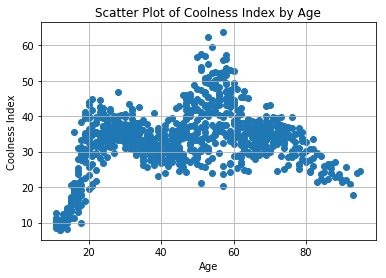

In [194]:
age = cool['Age']
coolness = cool['Coolness']

plt.scatter(age, coolness)
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Scatter Plot of Coolness Index by Age')
plt.grid()
plt.show()

#### Part (b). 

In [195]:
import statsmodels.api as sm
age_bin1 = ((age >= 11) & (age < 22)).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = ((age >= 77) & (age <= 95)).astype(int)
X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3, age_bin4=age_bin4,
                           age_bin5=age_bin5))
reg = sm.OLS(endog=coolness, exog=X_step, missing='drop')
reg_results = reg.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:               Coolness   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Mon, 19 Feb 2018   Prob (F-statistic):          3.73e-114
Time:                        01:09:16   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      20.1025      0.562     35.746      0.0

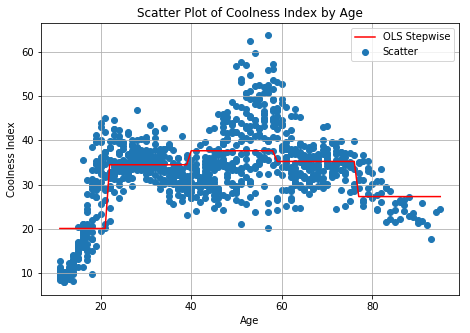

In [196]:
y_pred_1 = reg_results.predict(X_step)
plt.figure(figsize=(7.5,5))
plt.scatter(age, coolness, label='Scatter')
plt.plot(cool.Age, y_pred_1, color = 'r',label='OLS Stepwise')
plt.legend(loc='upper right')

plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Scatter Plot of Coolness Index by Age')
plt.grid()
plt.show()

In [197]:
b1, b2, b3, b4, b5 = reg_results.params
print('b1 =', b1, ', b2 =', b2,', b3 =', b3, ', b4 =', b4, ', b5 =', b5)
print('The predicted coolness of a 73-year old is', reg_results.params[3])

b1 = 20.1024572521 , b2 = 34.4757880776 , b3 = 37.6351054924 , b4 = 35.2254000402 , b5 = 27.2963782443
The predicted coolness of a 73-year old is 35.2254000402


#### Part (c). 

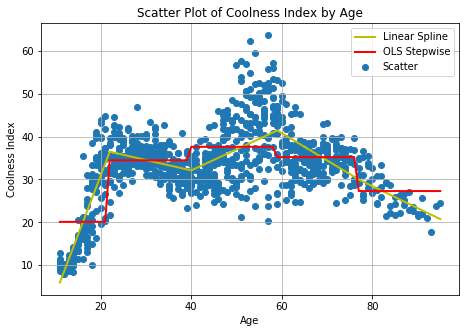

In [198]:
from scipy.interpolate import LSQUnivariateSpline
knots = [22,40,59,77]
spl_linear = LSQUnivariateSpline(age.values, coolness.values, knots, k=1)
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)
y_pred_2 = spl_linear(age_vec)

plt.figure(figsize=(7.5,5))
plt.scatter(age, coolness, label='Scatter')
plt.plot(age_vec, y_pred_2, color = 'y', linewidth=2, label='Linear Spline')
plt.plot(cool.Age, y_pred_1, color = 'r', linewidth=2, label='OLS Stepwise')
plt.legend(loc='upper right')

plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Scatter Plot of Coolness Index by Age')
plt.grid()
plt.show()


In [199]:
predicted_age2 = spl_linear(73)
print('The predicted coolness of a 73-year old is', predicted_age2)

The predicted coolness of a 73-year old is 32.536832389143306


#### Part (d). 

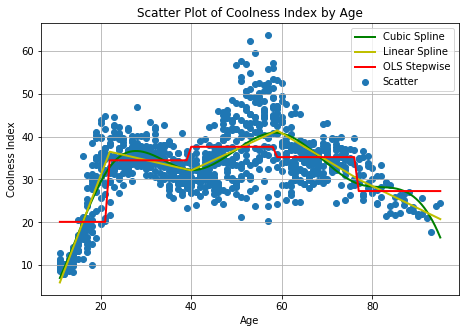

In [200]:
spl_cubic = LSQUnivariateSpline(age.values, coolness.values, knots, k=3)
age_vec = np.linspace(age.values.min(), age.values.max(), 1000)
y_pred_3 = spl_cubic(age_vec)

plt.figure(figsize=(7.5,5))
plt.scatter(age, coolness, label='Scatter')
plt.plot(age_vec, y_pred_3, color = 'g', linewidth=2, label='Cubic Spline')
plt.plot(age_vec, y_pred_2, color = 'y', linewidth=2, label='Linear Spline')
plt.plot(cool.Age, y_pred_1, color = 'r', linewidth=2, label='OLS Stepwise')
plt.legend(loc='upper right')

plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.title('Scatter Plot of Coolness Index by Age')
plt.grid()
plt.show()

In [201]:
predicted_age3 = spl_cubic(73)
print('The predicted coolness of 73-year old =', predicted_age3)

The predicted coolness of 73-year old = 31.262429389257864
